# Conditional Deep Convolutional GAN for MNIST

## Importing Libraries

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
from tensorflow.keras import layers
import time

from IPython import display

## Organize Dataset

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
onehot = np.eye(10)
labels = []
for i in range(train_labels.shape[0]):
    labels.append(onehot[train_labels[i]])
train_labels = np.array(labels)
train_labels.shape

(60000, 10)

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_labels = train_labels.reshape(train_labels.shape[0], 10, 1)

In [5]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28, 1)
(60000, 10, 1)


In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
BUFFER_SIZE = BUFFER_SIZE - BUFFER_SIZE % BATCH_SIZE

## Tensor Datasets

In [7]:
train_images = train_images[:BUFFER_SIZE]
train_labels = train_labels[:BUFFER_SIZE]

indices = np.arange(train_images.shape[0])
indices = np.random.shuffle(indices)

train_images = train_images[indices][0]
train_labels = train_labels[indices][0]

train_x = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_y = tf.convert_to_tensor(train_labels, dtype=tf.float32)
dataset_x = tf.split(train_x, num_or_size_splits=BUFFER_SIZE//BATCH_SIZE)
dataset_y = tf.split(train_y, num_or_size_splits=BUFFER_SIZE//BATCH_SIZE)

## Generator

In [8]:
class Generator(object):
    def __init__(self):
        self.model = self.make_generator_model()

    def make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(110,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((7, 7, 256)))
        assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert model.output_shape == (None, 7, 7, 128)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 14, 14, 64)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 28, 28, 1)

        return model
    
    def predict(self, x, y, training=False):
        return self.model(tf.concat([x, y], axis=1), training)

In [9]:
generator = Generator()
generator.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1379840   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

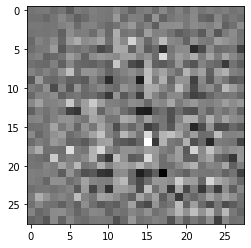

In [10]:
x = tf.random.normal([1, 100])
y = tf.convert_to_tensor([onehot[np.random.randint(0, 10)]], dtype=tf.float32)
y_fill = tf.convert_to_tensor(y.numpy() * np.ones([1, 28, 28, 10], dtype=np.float32))
generated_image = generator.predict(x, y)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')    # generated image from noise

## Discriminator

In [11]:
class Discriminator(object):
    def __init__(self):
        self.model = self.make_discriminator_model()

    def make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                        input_shape=[28, 28, 11]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

    def predict(self, x, y_fill, training=False):
        return self.model(tf.concat([x, y_fill], axis=3), training)

In [12]:
discriminator = Discriminator()
discriminator.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        17664     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [13]:
decision = discriminator.predict(generated_image, y_fill)
print(decision)

tf.Tensor([[-0.05325798]], shape=(1, 1), dtype=float32)


## Losses

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer

In [16]:
lr = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator.model,
                                 discriminator=discriminator.model)

## Training

In [18]:
EPOCHS = 100
noise_dim = 100
num_labels = 10
num_examples_to_generate = 16
seed_images = tf.random.normal([num_examples_to_generate, noise_dim])
seed_labels = tf.convert_to_tensor(onehot[np.random.randint(0, 10, (num_examples_to_generate, 1))], dtype=tf.float32)
seed_labels = tf.convert_to_tensor(seed_labels.numpy().reshape((num_examples_to_generate, 10)))
print(seed_labels)

tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]], shape=(16, 10), dtype=float32)


In [19]:
#@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    y = tf.convert_to_tensor(onehot[np.random.randint(0, 10, (BATCH_SIZE, 1))], dtype=tf.float32)
    y = tf.convert_to_tensor(y.numpy().reshape((BATCH_SIZE, 10)))
    
    y_fill = y.numpy().reshape((BATCH_SIZE, 1, 1, 10))
    y_fill = tf.convert_to_tensor(y_fill * np.ones([BATCH_SIZE, 28, 28, 10], dtype=np.float32))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator.predict(noise, y, training=True)

        labels_fill = labels.numpy().reshape((BATCH_SIZE, 1, 1, 10))
        labels = tf.convert_to_tensor(labels_fill * np.ones([BATCH_SIZE, 28, 28, 10], dtype=np.float32))

        real_output = discriminator.predict(images, labels, training=True)
        fake_output = discriminator.predict(generated_images, y_fill, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.model.trainable_variables))

In [20]:
def train(train_x, train_y, epochs):
    for epoch in range(epochs):
        start = time.time()

        for (image_batch, label_batch) in zip(train_x, train_y):
            train_step(image_batch, label_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed_images,
                                seed_labels)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed_images,
                            seed_labels)

In [21]:
def generate_and_save_images(model, epoch, test_input_image, test_input_label):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model.predict(test_input_image, test_input_label, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.uint8(predictions[i, :, :, 0] * 127.5 + 127.5), cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

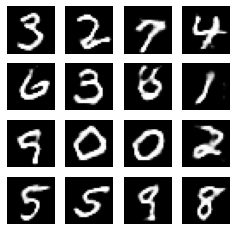

In [22]:
train(dataset_x, dataset_y, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:
generator.model.save('models/cdcgan-mnist-generator-28x28.h5')
discriminator.model.save('models/cdcgan-mnist-discriminator-28x28.h5')

## Test and GIF

In [24]:
anim_file = 'gifs/cdcgan_mnist.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [25]:
generator_test = Generator()
generator_test.model = tf.keras.models.load_model('models/cdcgan-mnist-generator-28x28.h5')

In [26]:
def test(digit):
    onehot = np.eye(10)
    x = tf.random.normal([1, 100])
    y = tf.convert_to_tensor([onehot[digit]], dtype=tf.float32)
    print(y)
    y_fill = tf.convert_to_tensor(y.numpy() * np.ones([1, 28, 28, 10], dtype=np.float32))
    generated_image = generator_test.predict(x, y)
    plt.imshow(np.uint8(generated_image[0, :, :, 0] * 127.5 + 127.5), cmap='gray')    # generated image from noise

tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


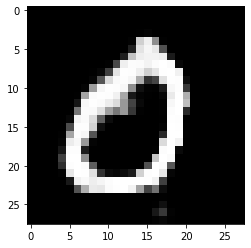

In [104]:
test(0)